### Goal ###
Find the nearest [California Data Exchange Center](https://cdec.water.ca.gov/) weather station to each of our California bins. This information will be used to assign each bin weather variable values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext memory_profiler

Lets load the station locations and the bins and take a look.

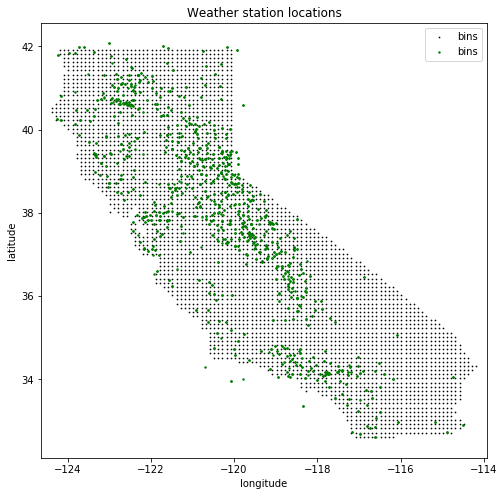

In [2]:
stations = pd.read_csv('../data/weather_station_data/target_stations.csv')

# Rename columns to project standards
stations.columns = ['station','elevation', 'lat', 'long']

# There is one station which has coordinates 0, 0. Get rid of it
stations = stations[stations.long != 0]

bins = pd.read_csv('../data/spatial_data/california_bins.csv')

plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(x=bins['long'], y=bins['lat'], color='black', s=0.5, label='bins')
plt.scatter(x=stations['long'], y=stations['lat'], color='green', s=2, label='bins')
plt.axis('equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Weather station locations')
plt.legend()
plt.show()

Since we have many bins which do not contain a weather monitoring station, the next step is to fill in their values from the nearest station. First find the nearest station to each bin. To do this we will use scipy.spatial.

In [3]:
bin_array = np.column_stack([bins['long'], bins['lat']])
bin_array

array([[-117.08,   32.62],
       [-116.98,   32.62],
       [-116.88,   32.62],
       ...,
       [-120.28,   41.92],
       [-120.18,   41.92],
       [-120.08,   41.92]])

In [4]:
station_array = np.column_stack([stations['long'], stations['lat']])
station_array

array([[-119.505  ,   37.151  ],
       [-118.2    ,   34.446  ],
       [-120.792  ,   41.237  ],
       ...,
       [-123.358  ,   39.42767],
       [-123.355  ,   39.43056],
       [-120.233  ,   38.847  ]])

In [5]:
from scipy import spatial

station_tree = spatial.cKDTree(station_array)
dist, indexes = station_tree.query(bin_array)

In [6]:
nearest_station_names = []
for index in indexes:
    nearest_station_names.append(stations.iloc[index, 0])

In [7]:
bins['nearest_station_name'] = nearest_station_names
bins.head()

,long,lat,nearest_station_name
0,-117.08,32.62,SMG
1,-116.98,32.62,SMG
2,-116.88,32.62,SMG
3,-116.78,32.62,POT
4,-116.68,32.62,POT


Starting with the temperature dataset as a test case, now we will make an hourly time series spanning from 2006 to 2016 and assign each bin a temprature from it's nearest station each hour. 

In [8]:
temp_data = pd.read_csv('../data/training_data/weather_data/TEMP.csv', low_memory=False)
temp_data.head()

,STATION_ID,DURATION,SENSOR_NUMBER,SENSOR_TYPE,DATE_TIME,OBS_DATE,VALUE,DATA_FLAG,UNITS
0,ACN,H,4,TEMP,20110101 2300,20110101 2300,38,,DEG F
1,ACN,H,4,TEMP,20110102 0000,20110102 0000,36,,DEG F
2,ACN,H,4,TEMP,20110102 0100,20110102 0100,37,,DEG F
3,ACN,H,4,TEMP,20110102 0200,20110102 0200,35,,DEG F
4,ACN,H,4,TEMP,20110102 0300,20110102 0300,34,,DEG F


Plan here is to use a multiindex first by station, then by datetime so when building the final training dataset each bin can ask for data from its nearest station at a particular time.

In [9]:
temp_data = temp_data.drop(["DURATION", "SENSOR_NUMBER", "SENSOR_TYPE", "DATE_TIME", "DATA_FLAG", "UNITS"], axis=1)
temp_data = temp_data[temp_data.VALUE != '---']
temp_data['OBS_DATE'] = pd.to_datetime(temp_data['OBS_DATE'])
temp_data = temp_data.set_index(['STATION_ID', 'OBS_DATE'])
temp_data = temp_data.sort_index()
temp_data = temp_data.drop_duplicates()
temp_data.head()

VALUE
STATION_ID OBS_DATE                 
ACN        2011-01-01 23:00:00    38
           2011-01-02 00:00:00    36
           2011-01-02 01:00:00    37
           2011-01-02 02:00:00    35
           2011-01-02 03:00:00    34

In [10]:
time_series = pd.date_range("2011-01-01 23:00:00", "2016-01-01 23:00:00", freq="60min")
time_series = time_series.to_series()
time_series

2011-01-01 23:00:00   2011-01-01 23:00:00
2011-01-02 00:00:00   2011-01-02 00:00:00
2011-01-02 01:00:00   2011-01-02 01:00:00
2011-01-02 02:00:00   2011-01-02 02:00:00
2011-01-02 03:00:00   2011-01-02 03:00:00
                              ...        
2016-01-01 19:00:00   2016-01-01 19:00:00
2016-01-01 20:00:00   2016-01-01 20:00:00
2016-01-01 21:00:00   2016-01-01 21:00:00
2016-01-01 22:00:00   2016-01-01 22:00:00
2016-01-01 23:00:00   2016-01-01 23:00:00
Freq: 60T, Length: 43825, dtype: datetime64[ns]

Now we make a dataframe of 'noxels' or n-dimentional voxels. Each row will be a bin at a specific time for each bin at all the times. Once we have this dataframe, we can go back though and assign weather variable values to each noxel.


In [11]:
def apply_to_bins(time_series, bins):
    return bins.assign(time = time_series)

%memit noxels = pd.concat(time_series.apply(apply_to_bins, args=(bins,)).tolist())
noxels.head()

peak memory: 17711.03 MiB, increment: 14107.08 MiB


,long,lat,nearest_station_name,time
0,-117.08,32.62,SMG,2011-01-01 23:00:00
1,-116.98,32.62,SMG,2011-01-01 23:00:00
2,-116.88,32.62,SMG,2011-01-01 23:00:00
3,-116.78,32.62,POT,2011-01-01 23:00:00
4,-116.68,32.62,POT,2011-01-01 23:00:00


In [ ]:
def assign_data(noxels, temp_data):
    return noxels.assign(temp = temp_data.loc[(noxels['station_name'], noxels['time'])])

%memit noxels = pd.concat(noxels.apply(assign_data, args=(temp_data,)).tolist())
noxels.head()